# Introduction

This Notebook is part of Coursera's 'IBM Professional Data Science Certificate'. We are inspecting a rocket launch database from SpaceX.

We will get the data, inspect it, preprocess the data for model building and evaluation as well as deployment, feedback and presentation. The structure of this Notebook orientates along Courseras course set-up. Lastly, I will issue some critique and comments on the techniques and procedures we used.

In [211]:
# Ensuring webscraping works (Optional)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Import all libaries
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import unicodedata
import prettytable
import csv, sqlite3
import folium
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


# 1. Getting the data
This section will import the data using `BeautifulSoup`.

In [213]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url)
soup = BeautifulSoup(response.text, 'html.parser')
soup.title.text

'List of Falcon 9 and Falcon Heavy launches - Wikipedia'

We collect all relevant column names from the HTML table header. 

In [214]:
html_tables = soup.find_all("tr")
# We index our target table
first_launch_table = html_tables[2]
print(first_launch_table)

<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>


Next, we iterate through the `<th>` elements and apply a custom function to extract column name one by one.

In [215]:
# Function to extract column names from headers
def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

column_names = []

for th in first_launch_table.find_all("th"):
    column_name = extract_column_from_header(th)
    if column_name:
        column_names.append(column_name)
        
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


We create an empty dictionary with keys from the extracted column names. Later, this dictionary will be converted into a Pandas dataframe.

In [216]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

We will define some helper functions that help to process the web scraped HTML table.

In [217]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass

We fill up the `launch_dict` with launch records extracted from table rows.

In [218]:
extracted_row = 0
# Extract each table
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    # get table rows
    for rows in table.find_all("tr"):
        # Check if first table heading is a number corresponding to the launch number
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False
        # Get table elements
        row = rows.find_all('td')
        # If it's a valid launch record, save the values in the dictionary
        if flag:
            extracted_row += 1
            # Flight Number value
            launch_dict['Flight No.'].append(flight_number)
            
            # Date and Time value (from the first column)
            datatimelist = date_time(row[0])
            
            # Date value
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            
            # Time value
            time = datatimelist[1]
            launch_dict['Time'].append(time)
              
            # Booster version (second column)
            bv = booster_version(row[1])
            if not bv:
                bv = row[1].a.string if row[1].a else 'Unknown'
            launch_dict['Version Booster'].append(bv)
            
            # Launch Site (third column)
            launch_site = row[2].a.string if row[2].a else 'Unknown'
            launch_dict['Launch site'].append(launch_site)
            
            # Payload (fourth column)
            payload = row[3].a.string if row[3].a else 'Unknown'
            launch_dict['Payload'].append(payload)
            
            # Payload Mass (fifth column)
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            # Orbit (sixth column)
            orbit = row[5].a.string if row[5].a else 'Unknown'
            launch_dict['Orbit'].append(orbit)
            
            # Customer (seventh column)
            customer = row[6].a.string if row[6].a else 'Unknown'
            launch_dict['Customer'].append(customer)
            
            # Launch outcome (eighth column)
            launch_outcome = list(row[7].strings)[0].strip() if row[7] else 'Unknown'
            launch_dict['Launch outcome'].append(launch_outcome)
            
            # Booster landing (ninth column)
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

Finally, we create the dataframe and display the webscraped results:

In [219]:
df = pd.DataFrame({key:pd.Series(value) for key, value in launch_dict.items()})
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10


Unfortunately, we need to continue using the below dataset which contains a bit more information. The above demnonstrates the procedure of webscraping data into Python for further analysis.

In [220]:
# Final df
file = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv"
df = pd.read_csv(file)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


# 2. Data Wrangling
Next, we will inspect and understand our data.

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

Next, let's inspect the percentage of missing values in each variable.

In [222]:
# Missing values
df.isnull().sum() / len(df)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

Let's inspect the number of launches for each site.

In [223]:
# Lets check some of the categorical features
attributes = ['LaunchSite', 'Orbit']

for attribute in attributes:
    print(f'Value counts for {attribute}:\n')
    print(df[attribute].value_counts(ascending=False))
    print("\n" + "="*40 + "\n")

Value counts for LaunchSite:

LaunchSite
CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64


Value counts for Orbit:

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64




In [224]:
# Check all landing outcomes
landing_outcomes = df['Outcome'].value_counts()

for i, outcome in enumerate(landing_outcomes.keys()):
    print(i, outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


What are the bad outcomes?

In [225]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Let's create a landing outcome label from the Outcome column.

In [226]:
# Element is zero if the corresponding row in `Outcome` is in the set `bad_outcome`; otherwise it's one.
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in df['Outcome']]

This variable will represent the classification variable that represents the outcome for each launch. If the value is zero, the first stage did not land successfully; one means the first stage landed successfully.

In [227]:
df['Class'] = landing_class
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [228]:
# Let's see the new dataframe
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


What is the overall success rate?

In [229]:
# Success rate
df['Class'].mean()

np.float64(0.6666666666666666)

# 3. Exploratory Data Analysis using SQL

We will use a SQL Notebook to understand and explore the SpaceX Dataset.

In [230]:
# Set-up for SQL
import sql
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Connect Python with the database.

In [231]:
prettytable.DEFAULT = 'DEFAULT'

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

The below is our preprocessed database. Each data science step is independent to each other in the Coursera Applied Data Science Capstone.

In [232]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [233]:
# We will remove blank rows from the table
%sql DROP TABLE IF EXISTS SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


[]

In [234]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
Done.


[]

### Inspecting the SQL Database

Let's inspect the database we are working with.

In [235]:
%%sql
SELECT * FROM SPACEXTABLE LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


We will display the names of the unique launch sites in the space mission.

In [236]:
%%sql
SELECT DISTINCT(Launch_Site) FROM SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


Next, we display 5 records where launch sites begin with the string 'CCA'.

In [237]:
%%sql
SELECT * FROM SPACEXTABLE WHERE Launch_Site LIKE 'CCA%' LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


We will display the total payload mass carried by boosters launched by NASA (CRS).

In [238]:
%%sql
SELECT SUM(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE Customer LIKE 'NASA (CRS)'

 * sqlite:///my_data1.db
Done.


SUM(PAYLOAD_MASS__KG_)
45596


We will display average payload mass carried by booster version F9 v1.1

In [239]:
%%sql
SELECT AVG(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE Booster_Version LIKE 'F9 v1.1'

 * sqlite:///my_data1.db
Done.


AVG(PAYLOAD_MASS__KG_)
2928.4


List the date when the first succesful landing outcome in ground pad was achieved.

In [240]:
%%sql
SELECT MIN(Date), Landing_Outcome FROM SPACEXTABLE

 * sqlite:///my_data1.db
Done.


MIN(Date),Landing_Outcome
2010-06-04,Failure (parachute)


List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

In [241]:
%%sql
SELECT Booster_Version, PAYLOAD_MASS__KG_ FROM SPACEXTABLE WHERE PAYLOAD_MASS__KG_ >= 4000 and PAYLOAD_MASS__KG_ <= 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version,PAYLOAD_MASS__KG_
F9 v1.1,4535
F9 v1.1 B1011,4428
F9 v1.1 B1014,4159
F9 v1.1 B1016,4707
F9 FT B1020,5271
F9 FT B1022,4696
F9 FT B1026,4600
F9 FT B1030,5600
F9 FT B1021.2,5300
F9 FT B1032.1,5300


List the total number of successful and failure mission outcomes

In [242]:
%%sql
SELECT Landing_Outcome, Count(*) AS Outcome_Count FROM SPACEXTABLE 
WHERE Landing_Outcome IN ('Success', 'Failure') 
GROUP BY Landing_Outcome;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Outcome_Count
Failure,3
Success,38


List the   names of the booster_versions which have carried the maximum payload mass. Use a subquery

In [243]:
%%sql
SELECT Booster_Version, PAYLOAD_MASS__KG_ FROM SPACEXTABLE WHERE PAYLOAD_MASS__KG_ LIKE (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE)

 * sqlite:///my_data1.db
Done.


Booster_Version,PAYLOAD_MASS__KG_
F9 B5 B1048.4,15600
F9 B5 B1049.4,15600
F9 B5 B1051.3,15600
F9 B5 B1056.4,15600
F9 B5 B1048.5,15600
F9 B5 B1051.4,15600
F9 B5 B1049.5,15600
F9 B5 B1060.2,15600
F9 B5 B1058.3,15600
F9 B5 B1051.6,15600


List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.

In [244]:
%%sql
SELECT CASE 
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'January'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'February'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'March'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'April'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'Mai'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'June'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'July'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'August'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'September'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'October'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'November'
    WHEN SUBSTR(Date, 6, 2) = '01' THEN 'December'
END AS Month, Booster_Version, Launch_Site, Landing_Outcome FROM SPACEXTABLE WHERE Landing_Outcome LIKE '%Failure%' AND SUBSTR(Date, 1, 4) = '2015';

 * sqlite:///my_data1.db
Done.


Month,Booster_Version,Launch_Site,Landing_Outcome
January,F9 v1.1 B1012,CCAFS LC-40,Failure (drone ship)
None,F9 v1.1 B1015,CCAFS LC-40,Failure (drone ship)


Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad)) between the date 2010-06-04 and 2017-03-20, in descending order.

In [245]:
%%sql
SELECT Landing_Outcome, COUNT(*) AS Outcome_Count FROM SPACEXTABLE WHERE Date BETWEEN '2010-06-04' AND '2017-03-20' GROUP BY Landing_Outcome ORDER BY Outcome_Count DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Outcome_Count
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


# Exploring and Preparing Data using Pandas

In [246]:
# We will work with a slightly different database
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df = pd.read_csv(URL)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


Let's see how the `FlightNumber` and `Payload` variables affect the launch outcome.

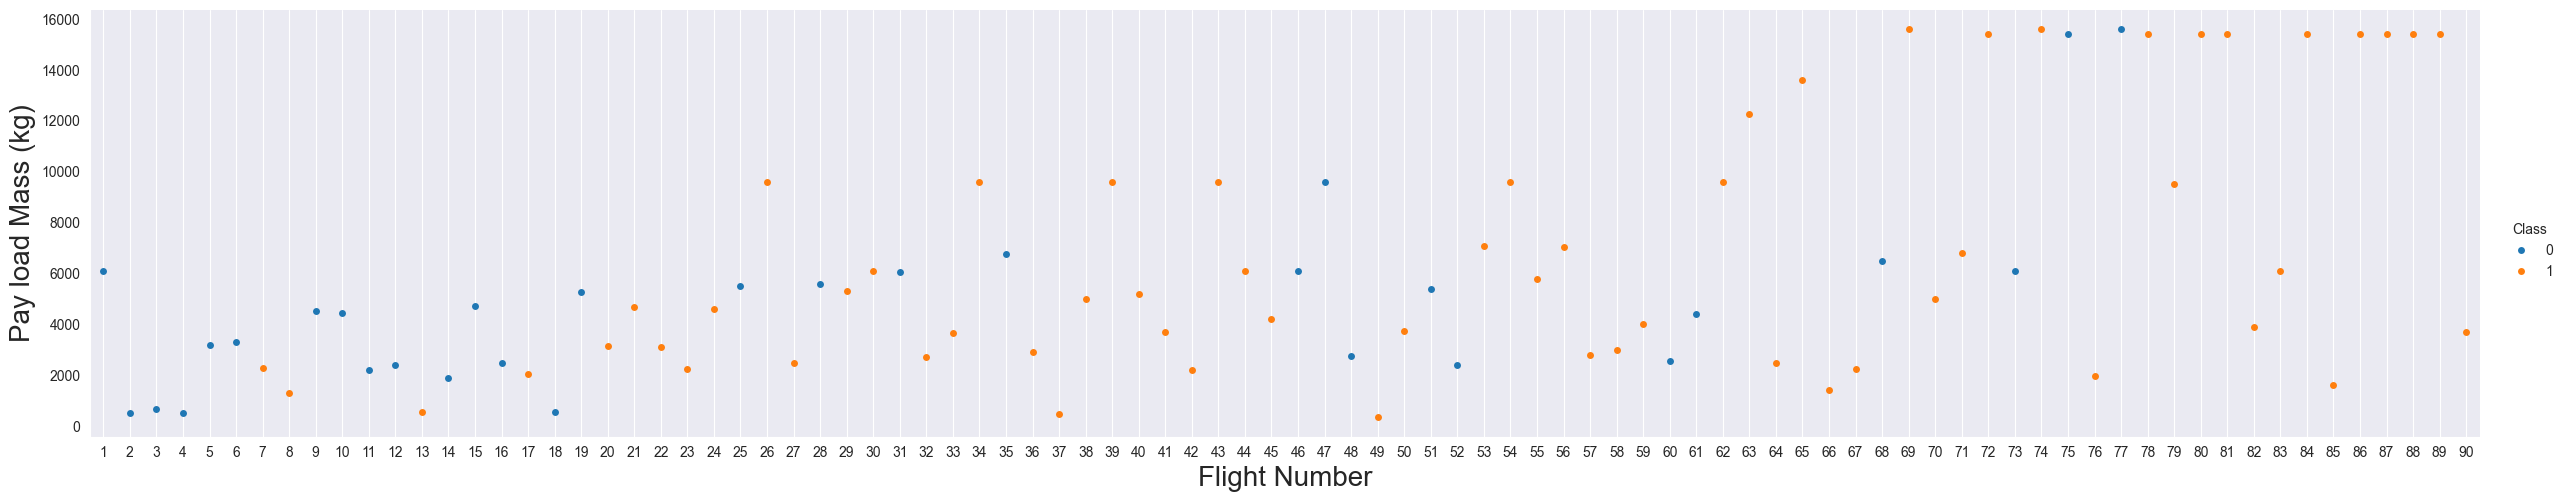

In [247]:
sns.catplot(y='PayloadMass', x='FlightNumber', hue='Class', data=df, aspect=5)
plt.xlabel('Flight Number', fontsize=20)
plt.ylabel('Pay load Mass (kg)', fontsize=20)
plt.grid()
plt.show()

Let's visualise the relationship between Flight Number and Launch Site,

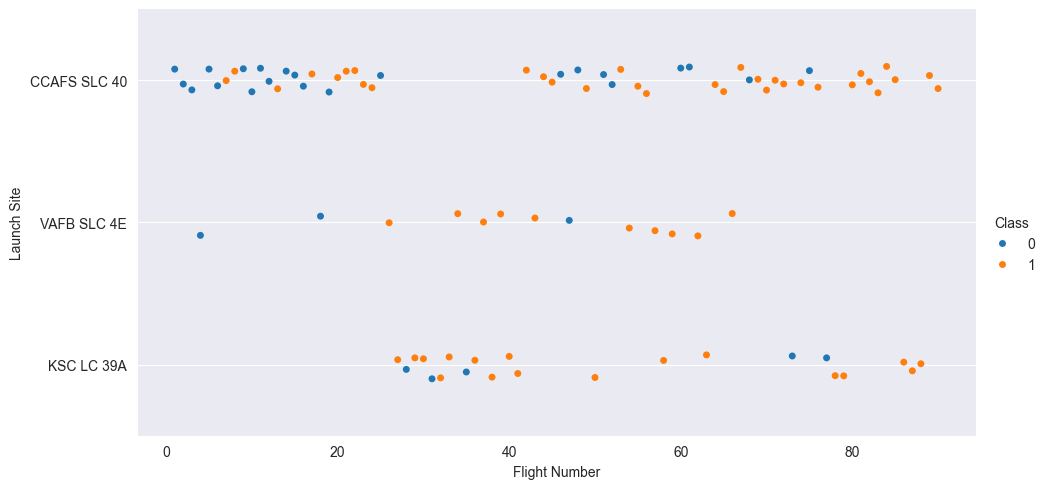

In [248]:
sns.catplot(y='LaunchSite', x='FlightNumber', data=df, hue='Class', aspect=2)
plt.xlabel('Flight Number', fontsize=10)
plt.ylabel('Launch Site', fontsize=10)
plt.grid()
plt.show()

Visualize the relationship between Payload Mass and Launch Site.

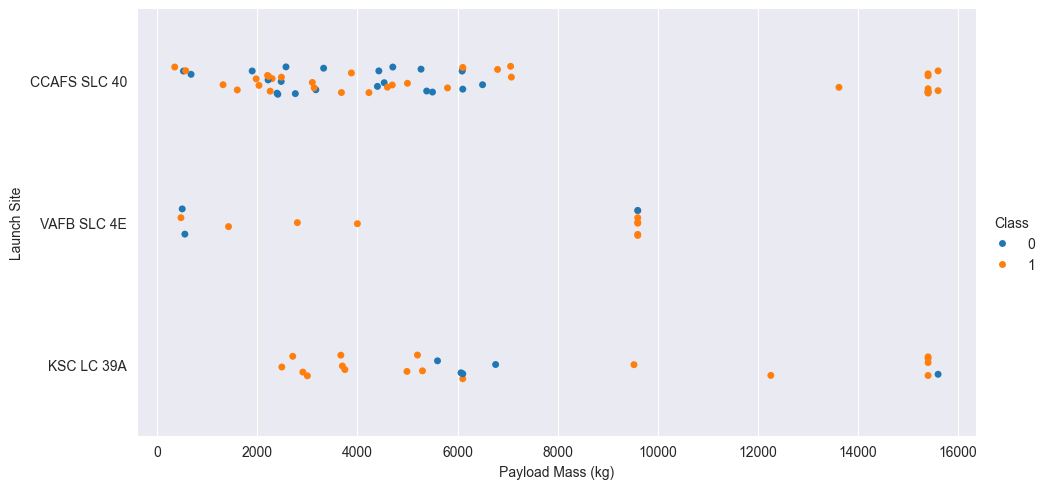

In [249]:
sns.catplot(x='PayloadMass', y='LaunchSite', data=df, aspect=2, hue='Class')
plt.xlabel('Payload Mass (kg)', fontsize=10)
plt.ylabel('Launch Site', fontsize=10)
plt.show()

Visualize the relationship between success rate of each orbit type.

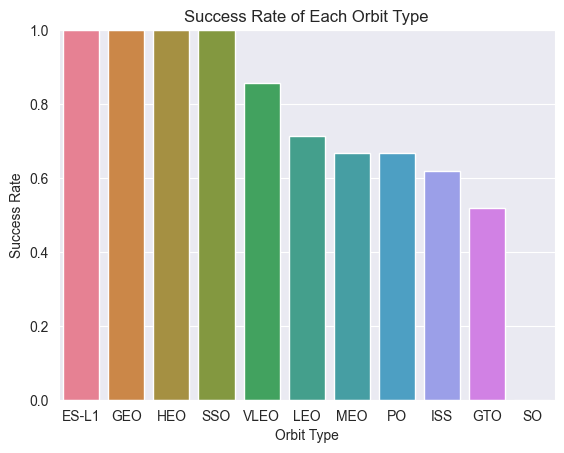

In [250]:
# Let's calculate the success rate for each orbit type
orbit_success_rate = df.groupby('Orbit')['Class'].mean().reset_index()
orbit_success_rate.columns = ['Orbit', 'Success Rate']

# Sort values for better visualisation
orbit_success_rate = orbit_success_rate.sort_values('Success Rate', ascending=False)

# Plot
sns.barplot(data=orbit_success_rate, x='Orbit', y='Success Rate', hue='Orbit', legend=False)
plt.xlabel('Orbit Type')
plt.ylabel('Success Rate')
plt.title('Success Rate of Each Orbit Type')
plt.ylim(0,1)
plt.show()

Visualize the relationship between FlightNumber and Orbit type.

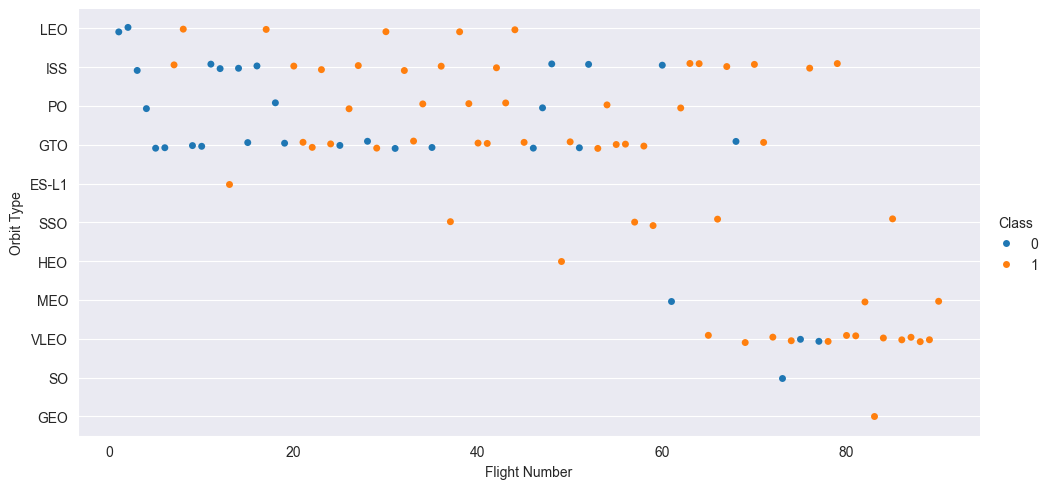

In [251]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(data=df, x='FlightNumber', y='Orbit', hue='Class', aspect=2)
plt.xlabel('Flight Number', fontsize=10)
plt.grid()
plt.ylabel('Orbit Type', fontsize=10)
plt.show()

Visualize the relationship between Payload Mass and Orbit type.

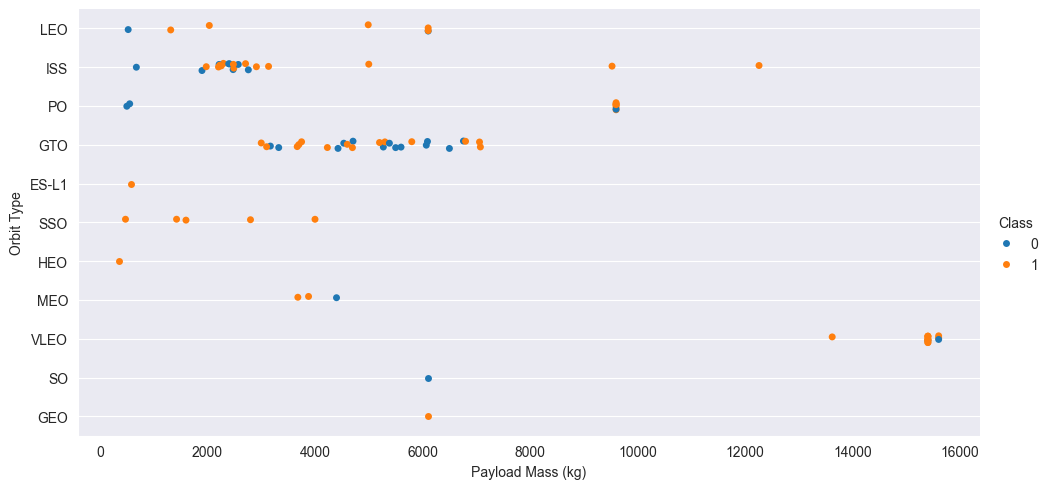

In [252]:
sns.catplot(data=df, x='PayloadMass', y='Orbit', hue='Class', aspect=2)
plt.xlabel('Payload Mass (kg)', fontsize=10)
plt.grid()
plt.ylabel('Orbit Type', fontsize=10)
plt.show()

Visualize the launch success yearly trend.

In [253]:
# Function to Extract years from the date
year = []
def extract_year():
    for i in df['Date']:
        year.append(i.split('-')[0])
    return year
extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


Plot a line chart with x axis to be the extracted year and y axis to be the success rate.

In [254]:
# Clean both 'Orbit' columns to ensure they match
df['Orbit'] = df['Orbit'].str.strip().astype(str)  # Remove spaces and ensure it's a string
orbit_success_rate['Orbit'] = orbit_success_rate['Orbit'].str.strip().astype(str)  # Same for orbit_success_rate

# Merge the two DataFrames, adding 'Success Rate' from orbit_success_rate into df
df = df.merge(orbit_success_rate, how='left', on='Orbit')

# Check the result
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Success Rate
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0,0.714286
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0,0.714286
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0,0.619048
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0,0.666667
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0,0.518519


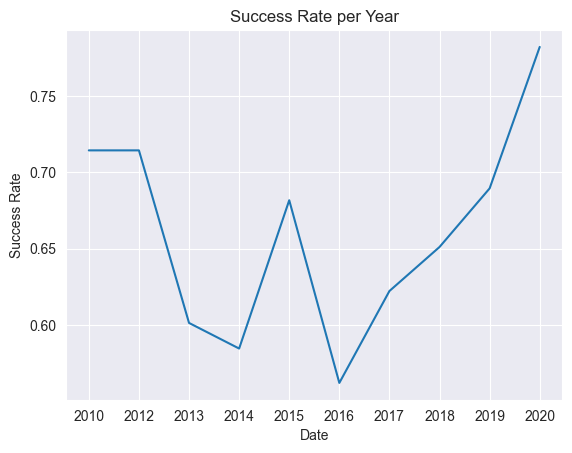

In [255]:
# Plot the lineplot
sns.set_style('darkgrid')
sns.lineplot(data=df, y='Success Rate', x='Date', errorbar=None)
plt.title('Success Rate per Year')
plt.xlabel('Date')
plt.ylabel('Success Rate')
plt.show()

Create dummy variables to categorical columns.

We will use the function <code>get_dummies</code> and <code>features</code> dataframe to apply OneHotEncoder to the column <code>Orbits</code>, <code>LaunchSite</code>, <code>LandingPad</code>, and <code>Serial</code>. Assign the value to the variable <code>features_one_hot</code>, display the results using the method head. Your result dataframe must include all features including the encoded ones.


In [256]:
# To see all columns
pd.set_option('display.max_columns', None)

features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]

# Apply OneHotEncoding using get_dummies and ensure 0 for False and 1 for True
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'], drop_first=False).astype(float)

# Display the fiarst few rows of the result
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Build interactive dashbaords
We will build interactive dashboards with Folium.

### Interactive Visual Analtics with Folium
The launch success rate may depend on the location and proximity of a launch site, i.e., the initial position of rocket trajectories. Let's get the dataset with latitude and longitute information.

In [257]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
df = pd.read_csv(URL)
df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


We select the relevant coordinates for each site. 

In [258]:
spacex_df = df[['Launch Site', 'Lat', 'Long', 'class']]
launch_site_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_site_df = launch_site_df[['Launch Site', 'Lat', 'Long']]
launch_site_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [259]:
# Get the lat , long into the launch site variable
launch_sites = dict(zip(launch_site_df['Launch Site'], zip(launch_site_df['Lat'], launch_site_df['Long'])))
launch_sites

{'CCAFS LC-40': (28.56230197, -80.57735648),
 'CCAFS SLC-40': (28.56319718, -80.57682003),
 'KSC LC-39A': (28.57325457, -80.64689529),
 'VAFB SLC-4E': (34.63283416, -120.6107455)}

Next, we will visualise the coordinates. We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.


In [260]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)
#site_map

We will use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate.

In [261]:
# Create a circle at NASA JSC's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a circle at NASA JSC's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon = DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

Lets add a circle for each launch site.

In [262]:
# Recreate the folium map centered at NASA JSC
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# Add circles and markers for each launch site
for site, coordinates in launch_sites.items():
    # Add circle
    folium.Circle(
        location=coordinates, 
        radius=1000, 
        color='#d35400', 
        fill=True
    ).add_to(site_map).add_child(folium.Popup(site))

    # Add text marker
    folium.Marker(
        location=coordinates, 
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 12px; color:#d35400;"><b>{site}</b></div>'
        )
    ).add_to(site_map)

# Display the map
site_map

The below highlights successful and failed launch attempts.

In [263]:
# Create a MarkerCluster
marker_cluster = MarkerCluster()

Creating a new column in `spacex_df` called `marker_color` to store the marker colors based on the `class` values.

In [264]:
# Define a function to assign colors
def assign_color(class_):
    return 'green' if class_ == 1 else 'red'

# Apply the function
spacex_df['marker_color'] = spacex_df.loc[:, 'class'].apply(assign_color)

# Display the updated dataframe
spacex_df.head()

/var/folders/bh/_p1bkhtn09b6syd7vz5f61pw0000gn/T/ipykernel_64291/2303477893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacex_df['marker_color'] = spacex_df.loc[:, 'class'].apply(assign_color)


,Launch Site,Lat,Long,class,marker_color
0,CCAFS LC-40,28.562302,-80.577356,0,red
1,CCAFS LC-40,28.562302,-80.577356,0,red
2,CCAFS LC-40,28.562302,-80.577356,0,red
3,CCAFS LC-40,28.562302,-80.577356,0,red
4,CCAFS LC-40,28.562302,-80.577356,0,red


For each launch result in `spacex_df` data frame, add a `folium.Marker` to `marker_cluster`.

In [265]:
# Create a map centered at Cape Canaveral
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# Add circles and markers for each launch site
for site, coordinates in launch_sites.items():
    # Add circle
    folium.Circle(
        location=coordinates, 
        radius=1000, 
        color='#d35400', 
        fill=True
    ).add_to(site_map).add_child(folium.Popup(site))

    # Add text marker
    folium.Marker(
        location=coordinates, 
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 12px; color:#d35400;"><b>{site}</b></div>'
        )
    ).add_to(site_map)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(site_map)

# Loop through the dataframe and add each launch result to the cluster
for index, row in spacex_df.iterrows():
    folium.Marker(
        location=[row['Lat'], row['Long']],
        popup=f"Launch Site: {row['Launch Site']}<br>Outcome: {'Success' if row['class'] == 1 else 'Failure'}",
        icon=folium.Icon(color=row['marker_color'])  # Use the given color from 'marker_color' column
    ).add_to(marker_cluster)

# Display the map
site_map

# 5. Predictive Analysis (Classification)
We will use the `spacex_df` dataframe to determine if the first stage will land. We will build a machine learning pipeline to predict if the first stage will land given the data from the preceding exercises.

In [266]:
# Import the predictor dataframe without the labels
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [267]:
# Assign X (predictor for ML)
X = np.asanyarray(X)
X

array([[1.00000000e+00, 6.10495941e+03, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 5.25000000e+02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 6.77000000e+02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [8.80000000e+01, 1.54000000e+04, 6.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [8.90000000e+01, 1.54000000e+04, 3.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [9.00000000e+01, 3.68100000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [268]:
# Import the dataset with the label
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv'
df2 = pd.read_csv(URL2)
df2.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [269]:
# Assign the label
y = np.asanyarray(df2['Class'])
y[:15]


array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.

In [270]:
# StandardScaler()
transform = preprocessing.StandardScaler().fit_transform(X)
transform

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

Use the function train_test_split to split the data X and y into training and test data.


In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [272]:
# We have a small test sample
y_test.shape

(18,)

Next we will create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.

### Logistic Regression

In [273]:
parameters ={"C":[0.01,0.1,1],
             'penalty':['l2'], 
             'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10, scoring='accuracy')
logreg_cv.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

In [274]:
# We output the GridSearchCV object for logistic regression and display the best parameters.
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7892857142857143


Let's calculate the accuracy on the test data using the method <code>score</code>:


In [275]:
test_acc = logreg_cv.best_estimator_.score(X_test, y_test)
print("Test set accuracy:", test_acc)

Test set accuracy: 0.9444444444444444


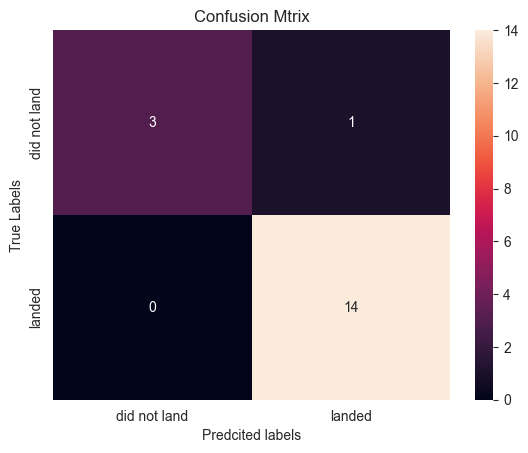

In [276]:
# Create a confusion matrix function
def plot_confusion_matrix(y, yhat):
    cm = confusion_matrix(y, yhat)
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel("Predcited labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Mtrix")
    ax.xaxis.set_ticklabels(['did not land', 'landed'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

# Display the result of the test set with a confusion matrix
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 14 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


Next, we create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


### SVM

In [277]:
# We define the parameters for GridSearchCV
parameters = {
    'kernel': ['linear', 'rbf'],  
    'C': np.logspace(-2, 2, 3),   
    'gamma': ['scale', 'auto']    
}
# We model SVC
svm = SVC()

In [278]:
# Apply GridSearchCV with limited iterations and easier parameter
svm_cv = GridSearchCV(svm, parameters, cv=2, scoring='accuracy') # Coursera uses cv=10 , which is not possible on a local machine
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e+00, 1.e+02]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [279]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(0.01), 'gamma': 'scale', 'kernel': 'linear'}
accuracy : 0.6944444444444444


We calculate the accuracy on the test data using `score`:

In [280]:
test_acc2 = svm_cv.best_estimator_.score(X_test, y_test)
print("Test set accuracy:", test_acc2)

Test set accuracy: 0.9444444444444444


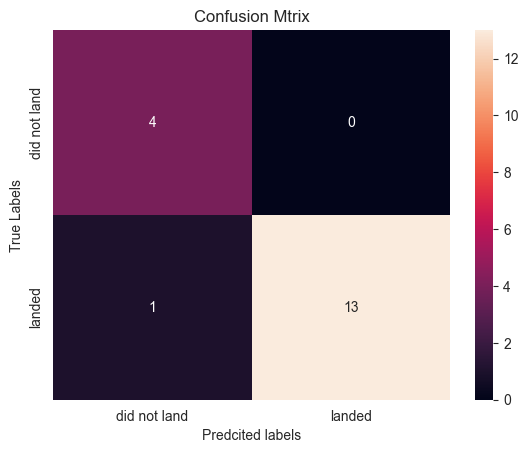

In [281]:
# We plot the confusion matrix
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

### KNN

Lastly, let's create a KNN and test the data again.

In [282]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [283]:
knn_cv = GridSearchCV(KNN, parameters, cv=10, scoring='accuracy')
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring='accuracy')

In [284]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.6928571428571428


And again, we calculate the accuracy of knn_cv on the test data.

In [285]:
knn_score = knn_cv.best_estimator_.score(X_test, y_test)
print("Test set accuracy:", knn_score)


Test set accuracy: 0.5


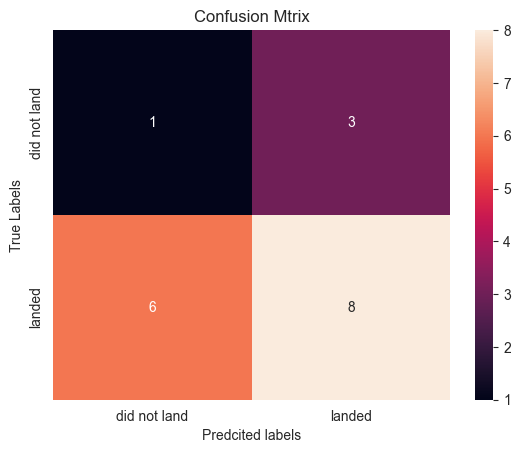

In [286]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

We can see that the `Logistic Regression` performed the best for us.

In [287]:
model_performance = pd.DataFrame({
    "Model" : ['Logistic Regression', 'SVM', 'KNN'],
    "Test Set Accuracy": [test_acc, test_acc2, knn_score],
    "Train Set Accuracy": [logreg_cv.best_score_, svm_cv.best_score_, knn_cv.best_score_]})
model_performance

,Model,Test Set Accuracy,Train Set Accuracy
0,Logistic Regression,0.944444,0.789286
1,SVM,0.944444,0.694444
2,KNN,0.500000,0.692857


You can find a detailed report about this project in the same GitHub folder!

# 6. IBM Project - Critique

This project covered almost all steps of a typical Data Science project, except the iterative process of evaluating the best model, further hyperparameter tuning and model deployment. I would like to address some issues discovered along the way:
- The webscraped database using `BeautifulSoup` is not the actual database the preprocessing and model building was based on
- It is best to split the data into a training and test set (using stratified sampling if any proportions need to be taken care of) right at the beginning to avoid data leakage
- We should have performed EDA onto a copy of the training set
- Randomized Search would have performed better than GridSearchCV
- We should have defined a pipeline for data preprocessing to allow reproducibility
- ColumnTransformer could have been used to automatically OneHotEncod categorical variables
- Customised transformer could have been implemented for advanced data Standardisation
- Feature Engineering is missing
- Extreme values have not been taken care of and `NaN` values were replaced with the `mean` instead of the `median`. Extreme values have a massive influence on the `mean`
- The test set has 18 values so the `ConfusionMatrix` is not too helpful when deciding the best model / fine-tuning hyperparameters